### DATA 643 Final Project: Yelp Dataset - Serendipity Recommender System
_Nathaniel Cooper, Angus Huang, Pavan Akula_

#### Background

From Zagat Ratings and Michelin Stars, to Yelp and Grubhub, restaurant recommendations are perhaps the oldest and most ubiquitous recommendation area. Having used movie review data for the previous project, we now want to apply our skills to another area of recommendation that has broad commercial application. Yelp is a digital platform for business reviews with special focus on restaurants and boasts 30 millions monthly unique users.

The use of recommender system is very widespread in retail and service industries. These industries usually have big amount of data where retrieving relevant small bit of data are from ocean of data is crucial to the success of the business. The interactive nature of the business with the customers or users make these industries ideal for recommender system. We hope to learn the established practice of such recommender systems and add our own creative flavor in doing so. The restaurant industry is naturally a prime target after the transportation system was disrupted by companies such as Uber, Lyft and Via.

#### Dataset

We decided to use a set of user ratings for restaurants in _Pittsburgh, PA_, available at https://www.yelp.com/dataset. The data consists 5,261,668 user-item ratings from 1 to 5 stars, written critiques, and feedback from other users as to whether the comment was useful,cool, or funny. The user and restaurant id’s take the form of hash id’s, so we have to bring in two other csv files to make the id’s human-readable. This data set is 3.53 GB and meets the size requirement for the final and is amenable to a wide range of recommender system methods: collaborative filtering, content-based, or matrix factorization.

Upon initial investigation we noticed that dataset is very sparse. We believe it is fair to assume once user finds restaurants that cater according to their taste most of them stick with same restaurant. This motivated us to develop recommender system that suggests restaurants that are dis-similar to user taste.

#### Methodology


In [1]:
#Load libraries and functions
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline

#Sparsity finction
def isSparse(array) :
    m, n = array.shape
    counter = 0
  
    # Count number of zeros
    # in the matrix
    for i in range(0,m) :
        for j in range(0,n) :
            if (array[i][j] == 0) :
                counter = counter + 1
  
    return (counter * 100 / (m * n))


In [2]:
#Load datasets
ratings_pd = pd.read_csv('https://raw.githubusercontent.com/ncooper76/DATA_643_Group/master/Final_Project/review_p.csv')
business_pd = pd.read_csv('https://raw.githubusercontent.com/ncooper76/DATA_643_Group/master/Final_Project/business_p.csv')
user_pd = pd.read_csv('https://raw.githubusercontent.com/ncooper76/DATA_643_Group/master/Final_Project/user_p.csv')

#Since user id is char datatype convert to numeric
business_pd['businessId'] = business_pd.index + 1
user_pd['userId'] = user_pd.index + 1

In [3]:
#apply numeric value to ratings dataset
ratings_pd = ratings_pd.merge(business_pd, how = 'left', left_on = 'business_id', right_on = 'business_id')
ratings_pd = ratings_pd.merge(user_pd, how = 'left', left_on = 'user_id', right_on = 'user_id')
ratings_pd = ratings_pd[['businessId', 'stars_x', 'userId']]
ratings_pd.columns = ['businessId', 'stars','userId']

In [4]:
#Calculate user-business ratings
user_visits = ratings_pd.groupby(['userId']).size().sort_values(ascending=True)

user_visits.head(10)

userId
1        1
24724    1
24723    1
24721    1
24719    1
24718    1
24715    1
24713    1
24712    1
24711    1
dtype: int64

Above Users 1, 24724, 24723 ... rated single restaurant.

In [5]:
user_visits.tail(10)

userId
1874     192
13757    208
37600    236
20546    241
1908     245
15052    247
41339    336
23696    337
35390    365
32526    466
dtype: int64

Users 32526 has rated most restaurants, 466 of them. Similarly, user 35390 has rated 365 restaurants. 

In [6]:
user_visits = pd.DataFrame(user_visits)
user_visits['userId'] = user_visits.index
user_visits = user_visits.reset_index(drop=True)
user_visits.columns = ['ratingCount','userId']
rating_visits = user_visits.groupby(['ratingCount']).size().sort_values(ascending=True)
rating_visits = pd.DataFrame(rating_visits)
rating_visits['users'] = rating_visits.index
rating_visits = rating_visits.reset_index(drop=True)
rating_visits.columns = ['users','ratingCount']
rating_visits = rating_visits.sort_values(by=['users'], ascending=False)
rating_visits.head(20)

,users,ratingCount
125,25606,1
124,6850,2
123,3183,3
122,1774,4
121,1039,5
120,702,6
119,526,7
118,386,8
117,298,9
116,246,10


There is a total of 25606 users in the dataset that have rated only once. Similarly, 6850 users have rated twice and 3183 users that rated thrice.

In [7]:
#Calculate user-business ratings
business_visits = ratings_pd.groupby(['businessId']).size().sort_values(ascending=True)

business_visits.head(10)

businessId
1234    3
899     3
169     3
898     3
1764    3
1172    3
663     3
409     3
2142    3
178     3
dtype: int64

Total of 3 users visited restaurants 1234, 899, 169 ... 

In [8]:
business_visits.tail(10)

businessId
660      604
999      632
36       656
87       677
2203     803
198      818
1074     902
330     1101
459     1265
1709    1477
dtype: int64

Total of 1477 users visited restaurant 1079. Similarly, a total of 1265 and 1101 users visited restaurant 459 and 330 ...

In [9]:
#pivot dataframe userId as columns and businessId as columns
ratings_df = ratings_pd.pivot(index = 'userId', columns ='businessId', values = 'stars').fillna(0)
ratings_df['userId'] = ratings_df.index

#Convert ratings dataframe to matrix
rating_matrix = ratings_df.values

#Check how sparse dataset is
sparsity = isSparse(rating_matrix)
print('Ratings Dataset is : {:.2f}% Sparse'.format(sparsity))

Ratings Dataset is : 99.82% Sparse


We are working with a very sparse dataset. One of the reason data is sparse could be once the user finds restaurants that cater according to their taste most of them stick with the same restaurant.

To overcome the problem, we will be using baseline prediction method using dataset average and user/business bias.

In [10]:
#Entire dataset mean
rawmean = ratings_pd['stars'].mean()

#Raw mean for user - user bias
user_rawmean = pd.DataFrame(ratings_pd.groupby(['userId'])['stars'].mean() - rawmean)
user_rawmean.columns = ['userBias']
user_rawmean['userId'] = user_rawmean.index
user_rawmean = user_rawmean.reset_index(drop=True)

#Raw mean for business - business bias
business_rawmean = pd.DataFrame(ratings_pd.groupby(['businessId'])['stars'].mean() - rawmean)
business_rawmean.columns = ['businessBias']
business_rawmean['businessId'] = business_rawmean.index
business_rawmean = business_rawmean.reset_index(drop=True)

In [11]:
#Convert user X business matrix to rows format
#Each rows with have user, business, rating
predicted_ratings_CtoR = pd.melt(ratings_df, id_vars='userId')
predicted_ratings_CtoR.columns = ['userId', 'businessId','stars']
predicted_ratings_CtoR['businessId'] = predicted_ratings_CtoR['businessId'].astype(int)

#Attach baseline average ratings
predicted_ratings_CtoR = predicted_ratings_CtoR.merge(user_rawmean, how='left', left_on=['userId'], right_on = ['userId'])
predicted_ratings_CtoR = predicted_ratings_CtoR.merge(business_rawmean, how='left', 
                                                      left_on=['businessId'], 
                                                      right_on = ['businessId'])

#Update ratings for only missing values
predicted_ratings_CtoR['stars'] = np.where(predicted_ratings_CtoR['stars'] == 0, 
                      rawmean + predicted_ratings_CtoR['userBias'] + predicted_ratings_CtoR['businessBias'], 
                      predicted_ratings_CtoR['stars'])

#Since ratings are between 1 and 5 change accordingly
predicted_ratings_CtoR.loc[predicted_ratings_CtoR['stars'] < 1, 'stars'] = 1
predicted_ratings_CtoR.loc[predicted_ratings_CtoR['stars'] > 5, 'stars'] = 5

In [12]:
#Convert predicted_ratings_CtoR back to user X business matrix
ratings_df = predicted_ratings_CtoR.pivot(index = 'userId', columns ='businessId', values = 'stars').fillna(0)

#remove predicted_ratings_CtoR dataframe to free up memory
del [[predicted_ratings_CtoR]]
gc.collect()

129

In [13]:
#Compute SVD martix factorization
rating_matrix = ratings_df.values
U, sigma, Vt = np.linalg.svd(rating_matrix, full_matrices=False)

#Get diagonal sigma
sigma_diag = np.diag(sigma)

#Recalculate ratings
predicted_ratings = np.dot(np.dot(U, sigma_diag), Vt)

rmse = mean_squared_error(predicted_ratings, rating_matrix)**0.5
print('RMSE : {:.6f}'.format(rmse))

RMSE : 0.000000


In [14]:
#Lets loop through reducing k value
r, c = rating_matrix.shape
k = min(r, c)
for i in range(5, 40, 5):

    # take columns less than k from U
    U_p = U[:,:k]
    # take rows less than k from V
    V_p = Vt[:k,:]
    # build the new S matrix with top k diagnal elements
    S_p = np.zeros((k, k), int)
    for j in range(k):
        S_p[j][j] = sigma[j]
    
    #Recalculate ratings
    predicted_ratings = np.dot(np.dot(U_p, S_p), V_p)

    #Calculate error difference
    diffM = rating_matrix - predicted_ratings
    
    #Frobenius Norm
    frobeniusNorm = np.linalg.norm(diffM, 'fro')
    
    #Singular value ratio has to be 90%
    if (k == min(r, c)):
        sigma_ratio = round(sum(sigma**2)/sum(sigma**2),3)
    else:
        less_singular_values = sigma[ np.where( sigma >= i ) ]
        sigma_ratio = round(sum(less_singular_values**2)/sum(sigma**2),3)
    
    
    #RMSE
    rmse = mean_squared_error(predicted_ratings, rating_matrix)**0.5
    print("RMSE : " + str(round(rmse,3)) + 
          ' Frobenius Norm : ' + str(round(frobeniusNorm,3)) + 
          ' k-Value reduced by : ' + str(min(r, c) - k) + 
          ' Singlar Value Ratio : ' + str(sigma_ratio)
         )
       
    #Eliminate rows with low sigma value
    k = min(r, c) - sigma[ np.where( sigma < i ) ].size

RMSE : 0.003 Frobenius Norm : 26.901 k-Value reduced by : 0 Singlar Value Ratio : 1.0
RMSE : 0.011 Frobenius Norm : 103.281 k-Value reduced by : 1335 Singlar Value Ratio : 1.0
RMSE : 0.021 Frobenius Norm : 203.767 k-Value reduced by : 1931 Singlar Value Ratio : 1.0
RMSE : 0.027 Frobenius Norm : 263.275 k-Value reduced by : 2121 Singlar Value Ratio : 1.0
RMSE : 0.031 Frobenius Norm : 295.559 k-Value reduced by : 2183 Singlar Value Ratio : 1.0
RMSE : 0.032 Frobenius Norm : 305.027 k-Value reduced by : 2195 Singlar Value Ratio : 1.0
RMSE : 0.032 Frobenius Norm : 307.623 k-Value reduced by : 2197 Singlar Value Ratio : 1.0


In [15]:
#Number of dimensions
k = min(r, c) - 1931
# take columns less than k from U
U_p = U[:,:k]
# take rows less than k from V
V_p = Vt[:k,:]
# build the new S matrix with top k diagnal elements
S_p = np.zeros((k, k), int)
for j in range(k):
    S_p[j][j] = sigma[j]

#Recalculate ratings
predicted_ratings = np.dot(np.dot(U_p, S_p), V_p) 

Single Value Ratio is high even when we remove 1931 dimensions is because the dataset has 2.2K restaurants and little over 42.2K users rating them. Also, using the baseline raw averages method has a direct influence on it.

In [16]:
#Apply visited column to original rating dataframe
ratings_pd['visited'] = 1

In [17]:
#Apply visited column to predicted values dataset
predicted_ratings = pd.DataFrame(predicted_ratings)
predicted_ratings['userId'] = predicted_ratings.index + 1
predicted_ratings_CtoR = pd.melt(predicted_ratings, id_vars='userId')
predicted_ratings_CtoR.columns = ['userId', 'businessId','predict']

#During conversion businessId starts from zero, so add 1
predicted_ratings_CtoR['businessId'] = predicted_ratings_CtoR['businessId'] + 1
predicted_ratings_CtoR['businessId'] = predicted_ratings_CtoR['businessId'].astype(int)

#Join on ratings dataframe apply visited flag
predicted_ratings_CtoR = predicted_ratings_CtoR.merge(ratings_pd, how='left', 
                                                      left_on=['userId','businessId'], 
                                                      right_on = ['userId','businessId'])
#Remove unused columns
predicted_ratings_CtoR = predicted_ratings_CtoR[['businessId', 'userId', 'predict','visited']]

In [18]:
#Create user profile
#User 32526 has rated about 466 resturants
sample_data = predicted_ratings_CtoR[(predicted_ratings_CtoR['userId'] == 32526)]

#Fill non-visited restaurantswith zero value
sample_data = sample_data.fillna(0)

#Split user dataset into visited and non-visited datasets
sample_visited = sample_data[sample_data['visited'] ==1]
sample_not_visited = sample_data[sample_data['visited'] ==0]

#Select random non-visited restaurants
#if visited restaurants are higher than non-visited use non-visited count else visited count 
random_count = sample_not_visited.shape[0] if sample_visited.shape[0] > sample_not_visited.shape[0] else sample_visited.shape[0]

#Get ramdom sample of non-visited restaurants and split into 2 sets
random_not_visited = sample_not_visited.sample(n=random_count)
random_not_visited1, random_not_visited2 = train_test_split(random_not_visited, test_size =0.2, random_state=0)

#apply one set to visited restaurants so we get good mix of visited and non-visited restaurants in training dataset
train_data = sample_visited.append(random_not_visited1)
test_data = random_not_visited2

In [19]:
#Clean up dataframe it has 93+ million records
del [[predicted_ratings_CtoR]]
gc.collect()

0

In [20]:
#Apply latent features to train and test datasets
#In this we will be using business features 'is_open','review_count','stars' - critic rating
train_data = pd.merge(train_data[['businessId','predict','visited']],
                     business_pd[['businessId','is_open','review_count','stars']],
                     how='left', on='businessId')
train_data = train_data.fillna(0)
rest_train_X = train_data[['predict','is_open','review_count','stars']]
rest_train_y = train_data[['visited']]

test_data = pd.merge(test_data[['businessId','predict','visited']],
                     business_pd[['businessId','is_open','review_count','stars']],
                     how='left', on='businessId')
test_data = test_data.fillna(0)
rest_test_X = test_data[['predict','is_open','review_count','stars']]
rest_test_y = test_data[['visited']]

Sample dataset is split into _training_ and _test_ datasets. Test dataset contains restaurants user has not visited. Training dataset contains combination of restaurants user has visited and not visited.

In [21]:
train_data.sample(n=10)

,businessId,predict,visited,is_open,review_count,stars
443,2081,3.882570,1.0,1,97,4.0
455,2136,3.142611,1.0,1,31,4.0
0,2,3.961115,1.0,1,16,3.5
662,519,5.001789,0.0,0,4,5.0
83,388,4.880974,1.0,1,7,4.0
526,561,2.187621,0.0,1,22,2.0
33,157,4.798342,1.0,1,28,3.5
251,1166,3.970885,1.0,1,46,3.5
6,21,3.053869,1.0,1,3,3.0
437,2034,4.867690,1.0,1,10,4.0


#### Logistic Regression

In [22]:
#Lets test how logit regression works on training dataset
#Split training dataset into training and validation datasets
tr_df, val_df = train_test_split(train_data, test_size =0.3, random_state=0)

#Create training dataset
tr_X = tr_df[['predict','is_open','review_count','stars']]
tr_y = tr_df[['visited']]

#Create validation dataset
val_X = val_df[['predict','is_open','review_count','stars']]
val_y = val_df[['visited']]

#Build logit model
logit_model=sm.Logit(tr_y,tr_X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.664168
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                visited   No. Observations:                  586
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            3
Date:                Mon, 16 Jul 2018   Pseudo R-squ.:                 0.03239
Time:                        18:50:56   Log-Likelihood:                -389.20
converged:                       True   LL-Null:                       -402.23
                                        LLR p-value:                 9.290e-06
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
predict          0.4607      0.138      3.332      0.001       0.190       0.732
is_open         -0.2734

In [23]:
#Sperate dependent and independent variables
predictors = ['predict','is_open','review_count','stars']
outcome = ['visited']

#Using the model get predictions
logval = LogisticRegression()
logval.fit(tr_df[predictors], tr_df[outcome].values.ravel())

#Prediction
y_val = logval.predict(val_df[predictors])
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(logval.score(val_df[predictors], 
                                                                                           val_df[outcome].values.ravel())))

Accuracy of logistic regression classifier on validation set: 0.56


#### Cross Validation

In [24]:
#Cross Validation
kfold = model_selection.KFold(n_splits=10, random_state=0)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, 
                                          tr_df[predictors], 
                                          tr_df[outcome].values.ravel(), 
                                          cv=kfold, 
                                          scoring=scoring)
print("8-fold cross validation average accuracy: %.3f" % (results.mean()))

8-fold cross validation average accuracy: 0.528


Cross validation attempts to avoid overfitting while still producing a prediction for each observation dataset. We are using 7-fold Cross-Validation to train our Logistic Regression model.

#### Confusion Matrix

In [25]:
#Confusion Matrix
confusion_matrix = confusion_matrix(val_y, y_val)
print(confusion_matrix)

[[ 36  77]
 [ 34 105]]


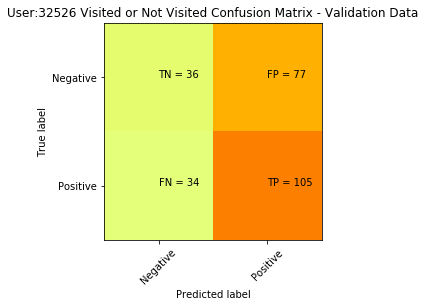

In [26]:
plt.clf()
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('User:32526 Visited or Not Visited Confusion Matrix - Validation Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(confusion_matrix[i][j]))
plt.show()

User 32526, 

- Visited 103 restaurants and model predicted correctly, _True Positives_. 
- The user did not visit 51 restaurants and model predicted as user visited them, _False Positives_. 
- The user visited 36 restaurants and model predicted as user not visit them, _False Negatives_. 
- Finally, the user did not visit 62 restaurants and model predicted correctly, _True Negatives_.

#### Compute precision, recall, F-measure and support

The precision is the ratio 
$$\begin{equation}
\frac{tp}{(tp + fp)}
\end{equation}$$ 

where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio 
$$\begin{equation}
\frac{tp}{(tp + fn)}
\end{equation}$$

where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.


In [27]:
print(classification_report(val_y, y_val))

             precision    recall  f1-score   support

        0.0       0.51      0.32      0.39       113
        1.0       0.58      0.76      0.65       139

avg / total       0.55      0.56      0.54       252



#### ROC Curve

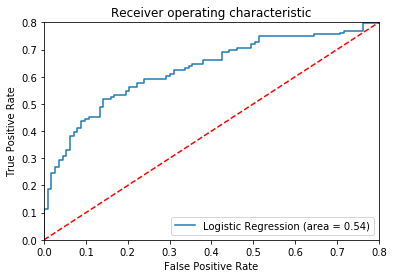

In [28]:
logit_roc_auc = roc_auc_score(val_y, logval.predict(val_X))
fpr, tpr, thresholds = roc_curve(val_y, logval.predict_proba(val_X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 0.8])
plt.ylim([0.0, 0.8])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Model Interpretation
- Precision of the model is 65%, the rate at which a positive prediction is accually positive.
- Recall of the model is also 65%, the rate at which true positive outcome predicted from the total positive outcomes reported.
- The average accuracy remains very close to the Logistic Regression model accuracy; hence, we can conclude that our model generalizes well.
- ROC suggests tradeoff between sensitivity and specificity is at 0.58. 

While applying _Logit Model_ to test data, we will use entire _train dataset_ to rebuild model again.

In [29]:
test_data.sample(n=10)

,businessId,predict,visited,is_open,review_count,stars
24,147,4.980419,0.0,0,89,4.5
82,1617,4.118181,0.0,0,335,4.0
88,901,3.482599,0.0,1,18,3.0
0,202,4.569840,0.0,0,6,4.5
76,619,3.914864,0.0,0,34,3.5
16,2037,3.271273,0.0,0,5,3.0
61,152,4.033157,0.0,1,30,4.0
1,1841,4.025689,0.0,1,72,4.0
56,1718,4.520885,0.0,0,4,4.0
5,1421,3.289243,0.0,0,3,3.0


In [30]:
#Build logit model
logit_model=sm.Logit(rest_train_y,rest_train_X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.657030
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                visited   No. Observations:                  838
Model:                          Logit   Df Residuals:                      834
Method:                           MLE   Df Model:                            3
Date:                Mon, 16 Jul 2018   Pseudo R-squ.:                 0.04341
Time:                        18:50:57   Log-Likelihood:                -550.59
converged:                       True   LL-Null:                       -575.57
                                        LLR p-value:                 8.122e-11
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
predict          0.4911      0.115      4.259      0.000       0.265       0.717
is_open         -0.3910

In [31]:
#Sperate dependent and independent variables
predictors = ['predict','is_open','review_count','stars']
outcome = ['visited']

#Using the model get predictions
logreg = LogisticRegression()
logreg.fit(train_data[predictors], train_data[outcome].values.ravel())

y_pred = logreg.predict(test_data[predictors])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_data[predictors], test_data[outcome].values.ravel())))


Accuracy of logistic regression classifier on test set: 0.43


In [32]:
test_data['suggested'] = y_pred
test_data[test_data['is_open']==1].sample(n=10)

,businessId,predict,visited,is_open,review_count,stars,suggested
30,1884,2.966409,0.0,1,6,2.5,0.0
10,357,4.002422,0.0,1,114,4.0,1.0
79,1999,4.421102,0.0,1,287,4.0,1.0
65,313,4.575729,0.0,1,97,4.5,1.0
23,1711,3.618158,0.0,1,3,3.5,0.0
88,901,3.482599,0.0,1,18,3.0,0.0
70,1043,2.929328,0.0,1,9,2.5,0.0
50,2123,4.031510,0.0,1,59,4.0,0.0
51,1660,4.598460,0.0,1,135,4.5,1.0
49,1083,3.281575,0.0,1,3,3.0,0.0


#### Conclusion
- Model suggests user may visit restaurants with _Latent Features_, stars above 3.5.

#### References
- https://www.youtube.com/watch?v=eZZQ3UTn484
- https://www.youtube.com/watch?v=0-o9VgOxe9Y&list=PLuKhJYywjDe96T2L0-zXFU5Up2jqXlWI9&index=11
- http://dataaspirant.com/2017/04/15/implement-logistic-regression-model-python-binary-classification/
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://www.ritchieng.com/machine-learning-cross-validation/
- https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/
- http://scikit-learn.org/stable/index.html
- https://www.geeksforgeeks.org/check-given-matrix-sparse-not/